In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import json

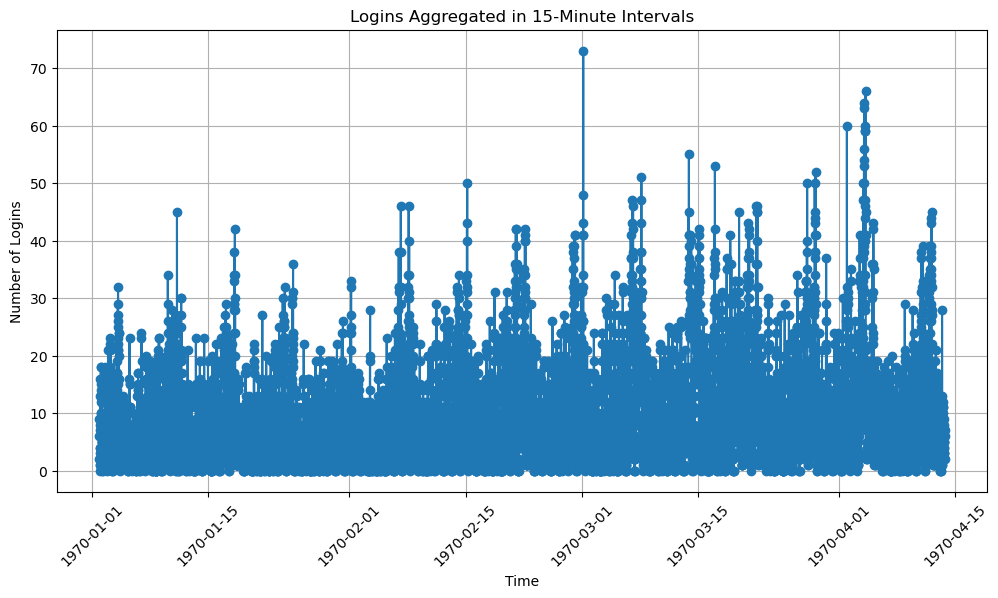

Processing complete. Aggregated login data saved as 'logins_aggregated.csv'.


In [156]:
# Load JSON file
with open('/Users/sarahberkin/Downloads/ultimate_challenge/logins.json', 'r') as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.DataFrame(data['login_time'], columns=['login_time'])
df['login_time'] = pd.to_datetime(df['login_time'])

# Set login_time as index
df.set_index('login_time', inplace=True)

# Aggregate logins into 15-minute intervals
df_resampled = df.resample('15min').size().reset_index(name='login_count')

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['login_time'], df_resampled['login_count'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.title('Logins Aggregated in 15-Minute Intervals')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Save processed data to CSV
df_resampled.to_csv('logins_aggregated.csv', index=False)

print("Processing complete. Aggregated login data saved as 'logins_aggregated.csv'.")

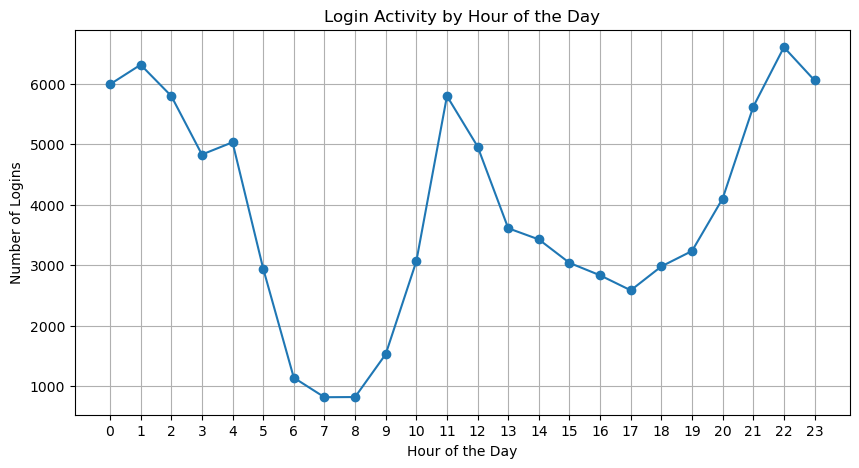

In [158]:
# Look for Daily Cycles
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
daily_trends = df.groupby('hour').size()

plt.figure(figsize=(10, 5))
plt.plot(daily_trends.index, daily_trends.values, marker='o', linestyle='-')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Logins')
plt.title('Login Activity by Hour of the Day')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

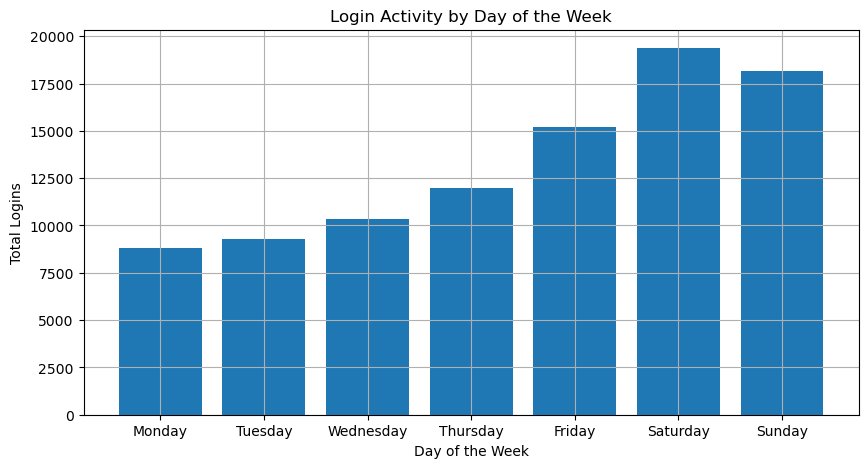

Processing complete. Aggregated login data saved as 'logins_aggregated.csv'.


In [160]:
# Weekly Patterns
daily_totals = df.groupby('day_of_week').size()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
plt.bar(days, daily_totals)
plt.xlabel('Day of the Week')
plt.ylabel('Total Logins')
plt.title('Login Activity by Day of the Week')
plt.grid(True)
plt.show()

# Save processed data to CSV
df_resampled.to_csv('logins_aggregated.csv', index=False)

print("Processing complete. Aggregated login data saved as 'logins_aggregated.csv'.")

In [162]:
import seaborn as sns

# Load JSON file
with open('/Users/sarahberkin/Downloads/ultimate_challenge/ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Convert date columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define retention: Active in last 30 days before dataset end
data_end = df['last_trip_date'].max()
df['retained'] = (df['last_trip_date'] >= (data_end - pd.Timedelta(days=30))).astype(int)

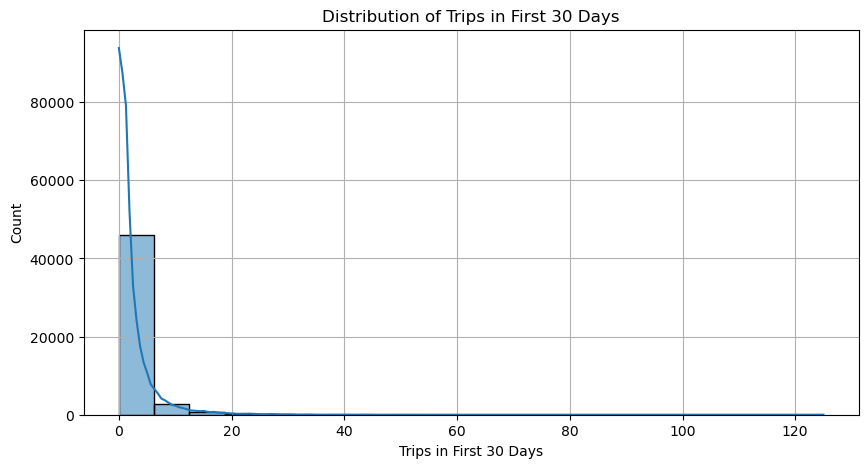

In [164]:
# Handle missing values
# Fill missing ratings with median (assuming NaNs in ratings are missing at random)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())

df.fillna({'phone': 'Unknown'}, inplace=True)  # Fill missing phone values

# Encode categorical variables
df = pd.get_dummies(df, columns=['city', 'phone', 'ultimate_black_user'], drop_first=True)

# Exploratory Data Analysis
plt.figure(figsize=(10, 5))
sns.histplot(df['trips_in_first_30_days'], bins=20, kde=True)
plt.title('Distribution of Trips in First 30 Days')
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Count')
plt.grid(True)
plt.show()

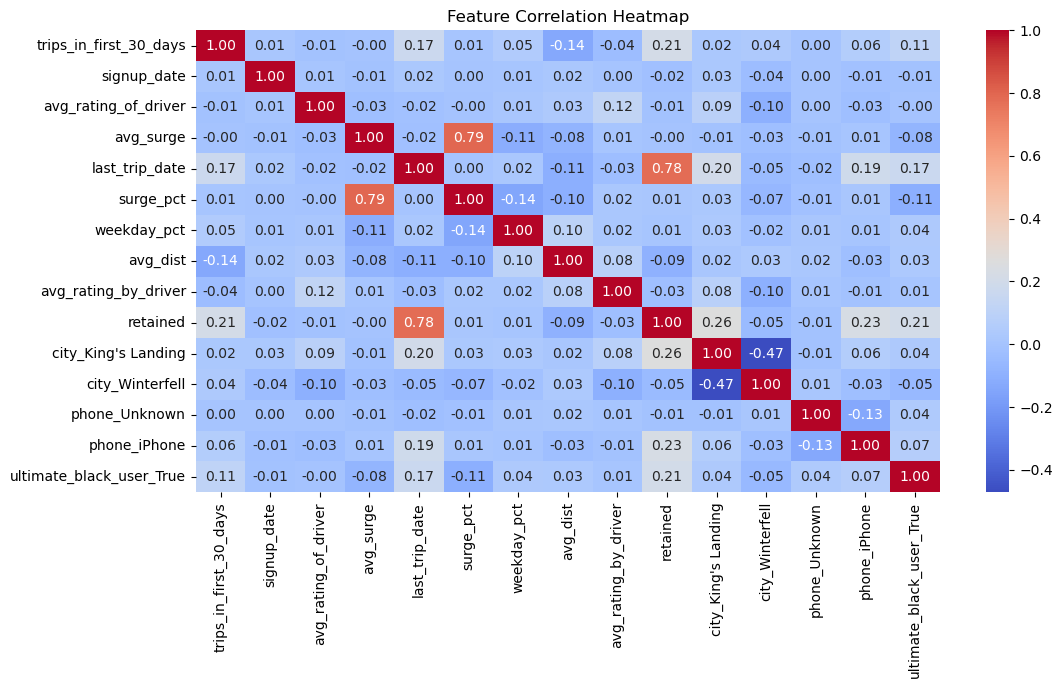

In [165]:
# Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

-The variable most highly correlated with retention is last trip date. This is not surprising as retention is based on whether the last trip was within the last 30 days. So, this variable should be removed from further analysis to prevent leakage. I will run an example of the model with and without this variable to see how much of an effect it had.

-Trips within past 30 days has the next level of correlation, suggesting users who have a lot of activity early on are more likely to stay for the long term. This suggests it's worth investing in campaigns and promos for early users.

-Ultimate Black users also showed to be nicely correlated, suggesting there's value in targeting loyalty programs for higher income or luxury-experience inclined users.

-Other variables that showed to be of at least mild correlation include: which city users are in, iPhone vs Android user, average distance, surge percent, and weekday percent.

In [172]:
# Save cleaned dataset
df.to_csv('ultimate_data_cleaned.csv', index=False)

print("Data cleaning and EDA complete. Processed dataset saved as 'ultimate_data_cleaned.csv'.")

Data cleaning and EDA complete. Processed dataset saved as 'ultimate_data_cleaned.csv'.


In [173]:
# Calculate the fraction of retained users
retention_rate = df['retained'].mean()
print(f"Fraction of retained users: {retention_rate:.2%}")

Fraction of retained users: 37.61%


After performing data cleaning and defining retention as users who had a trip in the last 30 days before the dataset end, we found that 37.61% of users were retained. This indicates a significant chunk of the user base that potentially could be room for improvement.

In [177]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df.drop(columns=['last_trip_date', 'signup_date', 'retained'])
y = df['retained']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Results with GradientBoostingClassifier + Imputer:
Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6219
           1       0.74      0.67      0.70      3781

    accuracy                           0.78     10000
   macro avg       0.77      0.76      0.77     10000
weighted avg       0.78      0.78      0.78     10000



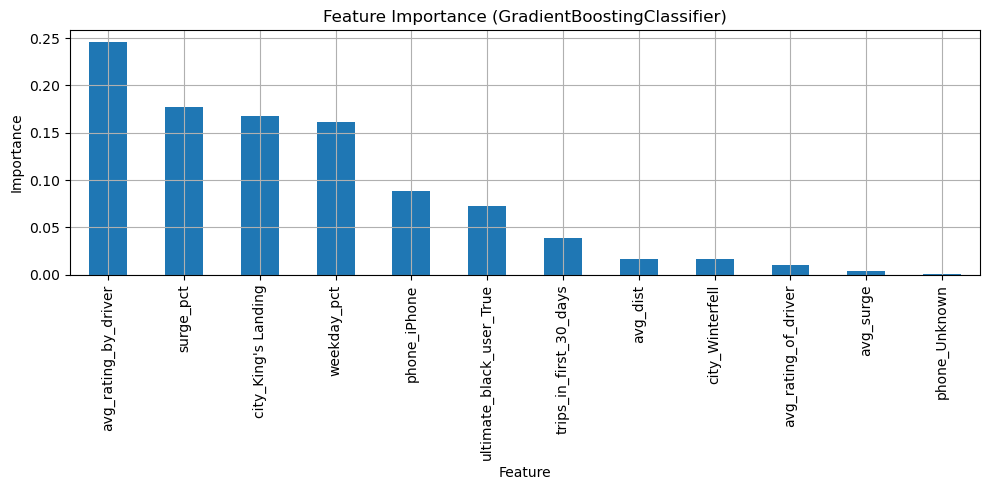

In [179]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Create a pipeline with imputer and classifier
pipeline_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change strategy to 'median', 'most_frequent', or 'constant'
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Fit and predict
pipeline_gb.fit(X_train_scaled, y_train)
y_pred_gb = pipeline_gb.predict(X_test_scaled)

# Evaluate
print("Results with GradientBoostingClassifier + Imputer:")
print(f'Accuracy: {accuracy_score(y_test, y_pred_gb):.2f}')
print(classification_report(y_test, y_pred_gb))

# Feature Importance
feature_importance_gb = pd.Series(
    pipeline_gb.named_steps['classifier'].feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
feature_importance_gb.plot(kind='bar')
plt.title('Feature Importance (GradientBoostingClassifier)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

In [180]:
print("Model training complete.")

Model training complete.


I will now run a version of the gradient boosting cluster model that has dropped "last_trip_date" and refined the features down to only the ones my heatmap showed to hold correlation to our target variable of retention.

Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6219
           1       0.73      0.67      0.70      3781

    accuracy                           0.78     10000
   macro avg       0.77      0.76      0.77     10000
weighted avg       0.78      0.78      0.78     10000



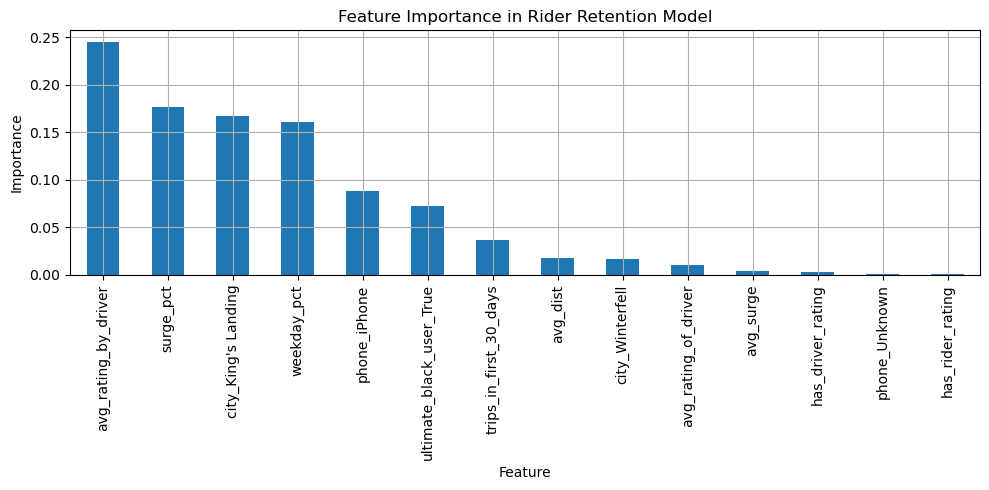

In [188]:
# Refined feature list
refined_features = [
    'trips_in_first_30_days',
    'ultimate_black_user_True',
    'city_King\'s Landing',
    'city_Winterfell',
    'phone_iPhone',
    'phone_Unknown',
    'avg_dist',
    'avg_rating_by_driver',
    'avg_rating_of_driver',
    'avg_surge',
    'surge_pct',
    'weekday_pct'
]

X = df[refined_features]
y = df['retained']

# Copy and create binary indicators for missing ratings
X_processed = X.copy()
X_processed['has_driver_rating'] = X_processed['avg_rating_of_driver'].notna().astype(int)
X_processed['has_rider_rating'] = X_processed['avg_rating_by_driver'].notna().astype(int)

# Impute missing ratings with column mean
X_processed['avg_rating_by_driver'] = X_processed['avg_rating_by_driver'].fillna(X_processed['avg_rating_by_driver'].mean())
X_processed['avg_rating_of_driver'] = X_processed['avg_rating_of_driver'].fillna(X_processed['avg_rating_of_driver'].mean())

# Final feature list including new engineered columns
final_features = X_processed.columns.tolist()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=final_features).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Rider Retention Model')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


In [190]:
print("Refined model training complete.")

Refined model training complete.


The difference between the two versions is minimal, just a slight 1% increase in precision on positive retention.

The predictive model demonstrates strong performance with an overall accuracy of 78%, effectively identifying patterns that influence rider retention. It performs particularly well in flagging users who are at risk of churning, which is valuable for targeted re-engagement efforts. While the model is slightly less accurate in predicting which users will be retained, it still provides reliable signals (precision = 0.73, recall = 0.67). With a solid foundation in place, this model can support data-driven retention strategies, and further tuning could enhance its ability to identify high-value users who are likely to stay engaged.

Adjusted Threshold: 0.3
Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.78      6219
           1       0.63      0.82      0.71      3781

    accuracy                           0.75     10000
   macro avg       0.75      0.76      0.74     10000
weighted avg       0.77      0.75      0.75     10000



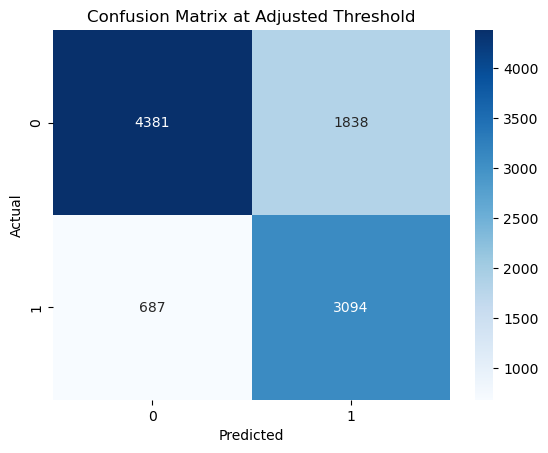

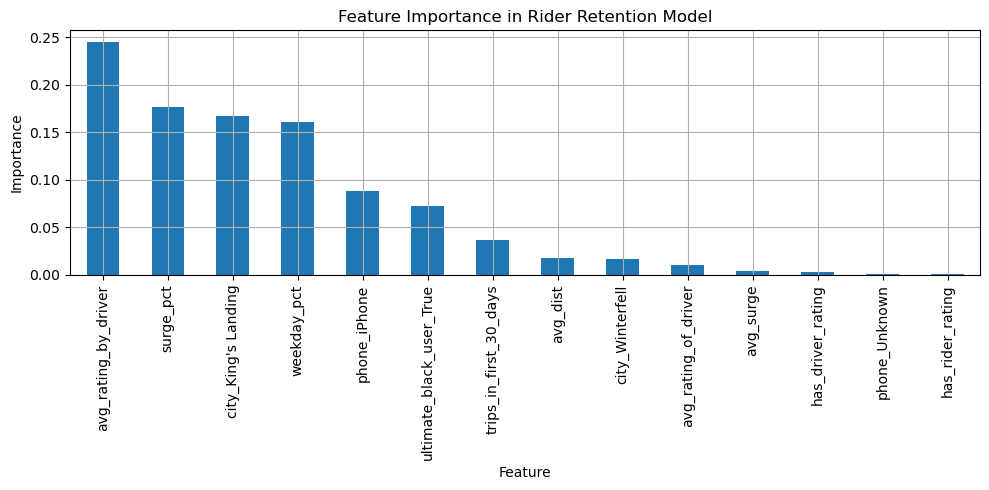

Refined model training complete with adjusted threshold.


In [194]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Train model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold to prioritize recall for retained users
threshold = 0.3  # Lower threshold increases recall
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate model
print(f"Adjusted Threshold: {threshold}")
print(f'Accuracy: {accuracy_score(y_test, y_pred_adjusted):.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_adjusted))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix at Adjusted Threshold')
plt.show()

# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=final_features).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Rider Retention Model')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Refined model training complete with adjusted threshold.")

# --- Business Recommendation ---
# The model identifies key retention drivers such as early usage (trips_in_first_30_days),
# premium service adoption (ultimate_black_user_True), and city-specific patterns.
# Ultimate can use these insights to offer onboarding incentives to new users,
# target high-value users with loyalty perks, and tailor marketing efforts by location.
# Proactively engaging likely-to-churn users with personalized offers can further boost retention.